In [1]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import tensorflow as tf
import theano.tensor as T
import matplotlib.pyplot as plt
import exoplanet as xo
import jax.numpy as jnp
import corner

from tensorflow.keras.models import load_model
from pymc3 import sampling_jax
from jax import nn, jit

import arviz as az
print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.4.0


/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling_jax.py:22: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [3]:
import jax
jax.__version__

'0.2.11'

In [3]:
import matplotlib
font = {'family' : 'verdana',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.style.use(['science','no-latex'])

## Emulator

In [4]:
path = 'data/models/test_model_2'
model = load_model(path)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [6]:
weights = model.get_weights()

In [7]:
input_offset = model.layers[0].mean.numpy()
input_scale = np.sqrt(model.layers[0].variance.numpy())

In [8]:
output_offset = np.array(model.layers[-1].offset)
output_scale = np.array(model.layers[-1].scale)

In [9]:
w = weights[3:-1:2]
b = weights[4::2]

In [10]:
inputs = np.array([[2.0, 2.0], [1.0, 1.0], [0.0, 0.0], [1.7, 1.7], [5., 5.], [3., 3.]]).T

In [11]:
def emulate(inputs):
    inputs = (inputs - input_offset) / input_scale
    for wi, bi in zip(w[:-1], b[:-1]):
        inputs = T.nnet.elu(T.dot(inputs, wi) + bi)
    outputs = T.dot(inputs, w[-1]) + b[-1]
    outputs = output_offset + outputs * output_scale
    return outputs

In [12]:
solar_test_inputs = T.stack([np.log10(4.57), 1., 0.05, 1.9, 7.2, 2.2])
outputs = emulate(solar_test_inputs)

In [13]:
y = outputs.eval()
print('Teff = ' + str(10**y[0]))
print('R = ' + str(10**y[1]))
# print('Z = ' + str(y[2]))
print('Prot = ' + str(10**y[3]))

Teff = 5818.890154770506
R = 0.9894546423002379
Prot = 24.09397770703743


## Data

In [14]:
bulk = pd.read_csv('data/inputs/bulk_inputs.csv')
bulk.head()

,KIC,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Teff,err_Teff,[M/H],err_[M/H],L,err_L,P_old,err_P
0,3427720,1.113,0.007,1.102,0.017,2.296,0.151,1.69,0.07,6045,77,-0.06,0.1,1.590,0.066,31.6,11.00
1,3656476,1.327,0.013,1.105,0.030,8.741,0.527,1.75,0.07,5668,77,0.25,0.1,1.779,0.077,48.0,10.40
2,3735871,1.107,0.009,1.132,0.024,1.836,0.231,1.73,0.09,6107,77,-0.04,0.1,1.638,0.073,15.8,2.15
3,4914923,1.383,0.010,1.134,0.022,6.410,0.437,1.66,0.06,5805,77,0.08,0.1,2.138,0.098,21.4,4.45
4,5184732,1.369,0.009,1.282,0.024,4.832,0.308,1.65,0.08,5846,77,0.36,0.1,1.947,0.061,19.9,1.60


In [15]:
hall = pd.read_csv('data/hall2021/data/table1.csv', index_col=0)
hall.head()

,KIC,Teff,eTeff,age,loage,upage,modmass,lomodmass,upmodmass,feh,...,u_nus*,i,l_i,u_i,P,l_P,u_P,flag,hrclass,source
0,1435467,6326,77,3.0164,0.3513,0.4951,1.3189,0.0513,0.0304,0.01,...,0.097947,63.426473,6.630832,10.191850,6.541180,0.620728,0.757775,0,H,L
1,2837475,6614,77,1.6270,0.1757,0.1118,1.4291,0.0209,0.0190,0.01,...,0.075408,70.745188,4.373721,6.031740,3.499114,0.154079,0.172064,0,H,L
2,3425851,6343,85,3.3200,0.6400,0.8500,1.1780,0.0490,0.0490,-0.04,...,0.478841,60.891571,22.743612,20.057892,8.082749,2.709672,8.637542,0,H,K
3,3427720,6045,77,2.2339,0.2396,0.2396,1.1080,0.0095,0.0209,-0.06,...,0.056955,56.407964,23.391922,22.854263,31.590512,11.821919,10.236450,0,MS,L
4,3456181,6384,77,2.0901,0.1278,0.1278,1.4975,0.0190,0.0304,-0.15,...,0.079464,58.206608,17.723228,20.416392,10.699926,2.790842,2.006340,0,H,L


In [16]:
hall.columns

Index(['KIC', 'Teff', 'eTeff', 'age', 'loage', 'upage', 'modmass', 'lomodmass',
       'upmodmass', 'feh', 'efeh', 'modlogg', 'upmodlogg', 'lomodlogg', 'nus*',
       'l_nus*', 'u_nus*', 'i', 'l_i', 'u_i', 'P', 'l_P', 'u_P', 'flag',
       'hrclass', 'source'],
      dtype='object')

In [17]:
hall['KIC'] = hall['KIC'].astype(str)

In [18]:
period_cols = ['KIC', 'P', 'l_P', 'u_P', 'flag', 'hrclass', 'feh', 'efeh']

hall[period_cols].head()

,KIC,P,l_P,u_P,flag,hrclass,feh,efeh
0,1435467,6.541180,0.620728,0.757775,0,H,0.01,0.1
1,2837475,3.499114,0.154079,0.172064,0,H,0.01,0.1
2,3425851,8.082749,2.709672,8.637542,0,H,-0.04,0.1
3,3427720,31.590512,11.821919,10.236450,0,MS,-0.06,0.1
4,3456181,10.699926,2.790842,2.006340,0,H,-0.15,0.1


In [19]:
df = bulk.merge(hall[period_cols], on='KIC')

In [20]:
asteroseismic_data = df.loc[(df['M'] + 1.5*df['err_M'] < 1.2) & (df['alpha'] + 1.5*df['err_alpha'] < 2.0)].copy()
asteroseismic_data

,KIC,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Teff,...,err_L,P_old,err_P,P,l_P,u_P,flag,hrclass,feh,efeh
0,3427720,1.113,0.007,1.102,0.017,2.296,0.151,1.69,0.07,6045,...,0.066,31.6,11.00,31.590512,11.821919,10.236450,0,MS,-0.06,0.10
1,3656476,1.327,0.013,1.105,0.030,8.741,0.527,1.75,0.07,5668,...,0.077,48.0,10.40,48.040844,12.682362,8.116435,0,MS,0.25,0.10
2,3735871,1.107,0.009,1.132,0.024,1.836,0.231,1.73,0.09,6107,...,0.073,15.8,2.15,15.810470,2.465683,1.821666,0,MS,-0.04,0.10
3,4914923,1.383,0.010,1.134,0.022,6.410,0.437,1.66,0.06,5805,...,0.098,21.4,4.45,21.393839,3.536735,5.394345,0,MS,0.08,0.10
5,6116048,1.240,0.009,1.062,0.020,5.753,0.338,1.70,0.09,6033,...,0.072,17.9,1.00,17.901072,1.185210,0.849631,0,MS,-0.23,0.10
7,6521045,1.519,0.006,1.132,0.012,6.611,0.382,1.68,0.06,5824,...,0.257,24.8,1.95,24.779457,2.030327,1.852825,0,MS,0.02,0.10
8,6933899,1.587,0.009,1.128,0.017,6.639,0.429,1.64,0.05,5832,...,0.125,28.9,4.25,28.906033,4.834900,3.699873,0,MS,-0.01,0.10
9,7296438,1.396,0.009,1.163,0.021,6.816,0.441,1.70,0.06,5775,...,0.101,45.6,26.20,45.585675,29.035076,23.384893,1,MS,0.19,0.10
10,7680114,1.422,0.006,1.132,0.012,7.331,0.482,1.69,0.05,5811,...,0.100,27.3,16.55,27.339763,13.484188,19.555251,0,MS,0.05,0.10
16,8394589,1.175,0.011,1.073,0.026,3.699,0.254,1.74,0.11,6143,...,0.092,10.9,0.60,10.862436,0.563070,0.604885,0,MS,-0.29,0.10


In [21]:
asteroseismic_data.columns

Index(['KIC', 'R', 'err_R', 'M', 'err_M', 'Age', 'err_Age', 'alpha',
       'err_alpha', 'Teff', 'err_Teff', '[M/H]', 'err_[M/H]', 'L', 'err_L',
       'P_old', 'err_P', 'P', 'l_P', 'u_P', 'flag', 'hrclass', 'feh', 'efeh'],
      dtype='object')

In [22]:
asteroseismic_data['err_P'] = (asteroseismic_data['l_P'] + asteroseismic_data['u_P']) / 2

In [23]:
# PLEIADES
df_pleiades = pd.read_csv('data/apjabbf58t5_mrt.txt', skiprows=35, nrows=330, delimiter='\s+', header=None)
teff_for_mask_pleiades = np.array(df_pleiades[14])
mask_pleiades = np.where((teff_for_mask_pleiades > 5677) & (teff_for_mask_pleiades < 5877))[0]
age_pleiades = np.array(df_pleiades[1])[mask_pleiades]
err_age_pleiades = age_pleiades * .2
teff_pleiades = teff_for_mask_pleiades[mask_pleiades]
err_teff_pleiades = np.ones(len(teff_pleiades)) * 100.
P_pleiades = np.array(df_pleiades[15])[mask_pleiades]
err_P_pleiades = P_pleiades*.2

In [24]:
# PRAESOPE
df_praesepe = pd.read_csv('data/apjabbf58t5_mrt.txt', skiprows=365, nrows=359, delimiter='\s+', header=None)
teff_for_mask_praesepe = np.array(df_praesepe[14])
mask_praesepe = np.where((teff_for_mask_praesepe > 5677) & (teff_for_mask_praesepe < 5877))[0]
age_praesepe = np.array(df_praesepe[1])[mask_praesepe]
err_age_praesepe = age_praesepe * .2
teff_praesepe = teff_for_mask_praesepe[mask_praesepe]
err_teff_praesepe = np.ones(len(teff_praesepe)) * 100.
P_praesepe = np.array(df_praesepe[15])[mask_praesepe]
err_P_praesepe = P_praesepe*.2

In [25]:
# NGC 6811
df_ngc6811 = pd.read_csv('data/apjabbf58t5_mrt.txt', skiprows=724, nrows=885-724, delimiter='\s+', header=None)
teff_for_mask_ngc6811 = np.array(df_ngc6811[15])
mask_ngc6811 = np.where((teff_for_mask_ngc6811 > 5677) & (teff_for_mask_ngc6811 < 5877))[0]
age_ngc6811 = np.array(df_ngc6811[2])[mask_ngc6811]
err_age_ngc6811 = age_ngc6811 * .2
teff_ngc6811 = teff_for_mask_ngc6811[mask_ngc6811]
err_teff_ngc6811 = np.ones(len(teff_ngc6811)) * 100.
P_ngc6811 = np.array(df_ngc6811[16])[mask_ngc6811]
err_P_ngc6811 = P_ngc6811*.2

In [26]:
# NGC 752
df_ngc752 = pd.read_csv('data/apjabbf58t5_mrt.txt', skiprows=885, nrows=893-885, delimiter='\s+', header=None)
teff_for_mask_ngc752 = np.array(df_ngc752[13])
mask_ngc752 = np.where((teff_for_mask_ngc752 > 5677) & (teff_for_mask_ngc752 < 5877))[0]
age_ngc752 = np.array(df_ngc752[2])[mask_ngc752]
err_age_ngc752 = age_ngc752 * .2
teff_ngc752 = teff_for_mask_ngc752[mask_ngc752]
err_teff_ngc752 = np.ones(len(teff_ngc752)) * 100.
P_ngc752 = np.array(df_ngc752[14])[mask_ngc752]
err_P_ngc752 = P_ngc752*.2

In [27]:
# NGC 6819
df_ngc6819 = pd.read_csv('data/apjabbf58t5_mrt.txt', skiprows=894, nrows=923-894, delimiter='\s+', header=None)
teff_for_mask_ngc6819 = np.array(df_ngc6819[15])
mask_ngc6819 = np.where((teff_for_mask_ngc6819 > 5677) & (teff_for_mask_ngc6819 < 5877))[0]
age_ngc6819 = np.array(df_ngc6819[2])[mask_ngc6819]
err_age_ngc6819 = age_ngc6819 * .2
teff_ngc6819 = teff_for_mask_ngc6819[mask_ngc6819]
err_teff_ngc6819 = np.ones(len(teff_ngc6819)) * 100.
P_ngc6819 = np.array(df_ngc6819[16])[mask_ngc6819]
err_P_ngc6819 = P_ngc6819*.2

In [28]:
cluster_df = pd.DataFrame({'Age':np.concatenate((age_pleiades, 
                                                 age_praesepe, 
                                                 age_ngc6811,
                                                 age_ngc752,
                                                 age_ngc6819)),
                           'err_Age':np.concatenate((err_age_pleiades, 
                                                     err_age_praesepe, 
                                                     err_age_ngc6811,
                                                     err_age_ngc752,
                                                     err_age_ngc6819)),
                           'P':np.concatenate((P_pleiades, 
                                               P_praesepe, 
                                               P_ngc6811,
                                               P_ngc752,
                                               P_ngc6819)),
                           'err_P':np.concatenate((err_P_pleiades, 
                                                   err_P_praesepe, 
                                                   err_P_ngc6811,
                                                   err_P_ngc752,
                                                   err_P_ngc6819)),
                           'Teff':np.concatenate((teff_pleiades, 
                                                  teff_praesepe, 
                                                  teff_ngc6811,
                                                  teff_ngc752,
                                                  teff_ngc6819)),
                           'err_Teff':np.concatenate((err_teff_pleiades, 
                                                      err_teff_praesepe, 
                                                      err_teff_ngc6811,
                                                      err_teff_ngc752,
                                                      err_teff_ngc6819)),
                           'M':np.ones(len(age_pleiades)+
                                       len(age_praesepe)+
                                       len(age_ngc6811)+
                                       len(age_ngc752)+
                                       len(age_ngc6819))*1.,
                           'err_M':np.ones(len(age_pleiades)+
                                           len(age_praesepe)+
                                           len(age_ngc6811)+
                                           len(age_ngc752)+
                                           len(age_ngc6819))*.5,
                           'alpha':np.ones(len(age_pleiades)+
                                           len(age_praesepe)+
                                           len(age_ngc6811)+
                                           len(age_ngc752)+
                                           len(age_ngc6819))*1.6,
                           'err_alpha':np.ones(len(age_pleiades)+
                                               len(age_praesepe)+
                                               len(age_ngc6811)+
                                               len(age_ngc752)+
                                               len(age_ngc6819))*.25,
                           'feh':np.concatenate((np.ones(len(age_pleiades))*0.,
                                                 np.ones(len(age_praesepe))*.15,
                                                 np.ones(len(age_ngc6811))*0.,
                                                 np.ones(len(age_ngc752))*0,
                                                 np.ones(len(age_ngc6819))*0)),
                           'efeh':np.ones(len(age_pleiades)+
                                          len(age_praesepe)+
                                          len(age_ngc6811)+
                                          len(age_ngc752)+
                                          len(age_ngc6819))*.05,
                           'R':np.ones(len(age_pleiades)+
                                          len(age_praesepe)+
                                          len(age_ngc6811)+
                                          len(age_ngc752)+
                                          len(age_ngc6819))*1.,
                           'err_R':np.ones(len(age_pleiades)+
                                           len(age_praesepe)+
                                           len(age_ngc6811)+
                                           len(age_ngc752)+
                                           len(age_ngc6819))*.25,
                           })

In [29]:
data_with_clusters = asteroseismic_data.append(cluster_df, ignore_index=True)
# data_with_clusters

In [30]:
sim_data = pd.read_csv('data/ANN_pop_test.dat').rename(columns={'Alpha':'alpha',
                                                                'Alpha_err':'err_alpha',
                                                                'Age_err':'err_Age',
                                                                'Mass':'M',
                                                                'Mass_err':'err_M',
                                                                'Period':'P',
                                                                'Period_err':'err_P',
                                                                '[Fe/H]':'feh',
                                                                '[Fe/H]_err':'efeh',
                                                                'Teff_err':'err_Teff',
                                                                'Radius':'R',
                                                                'Radius_err':'err_R'})

# sim_data = sim_data.iloc[np.where((sim_data['Age'] > 1.) & (sim_data['Age'] < 13.))]

In [31]:
sim_data[:10]

,Teff,err_Teff,feh,efeh,P,err_P,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Zsurf,Zsurf_err,Xsurf
0,5743.639947,80.0,-0.135299,0.1,26.894443,2.621747,1.004549,0.029804,0.963491,0.1,6.509037,1.383131,1.800809,0.2,0.013030,0.002,0.752531
1,5584.539131,80.0,-0.140818,0.1,27.613564,2.812776,0.914082,0.027286,0.889725,0.1,5.590414,1.349657,1.878282,0.2,0.012269,0.002,0.750464
2,5587.273605,80.0,-0.077146,0.1,26.472649,2.780210,0.952613,0.028317,0.934887,0.1,5.547659,1.262071,1.871737,0.2,0.014442,0.002,0.744485
3,5663.911191,80.0,-0.253773,0.1,32.908424,3.132047,0.948960,0.028902,0.861527,0.1,11.403897,2.264412,1.855520,0.2,0.009996,0.002,0.769591
4,5642.550375,80.0,-0.223412,0.1,30.810809,3.027252,0.953693,0.028723,0.878854,0.1,8.064068,1.706695,1.946555,0.2,0.013770,0.002,0.752267
5,5709.147099,80.0,0.058060,0.1,14.898173,1.493358,0.895062,0.027146,0.952262,0.1,2.113824,0.376627,1.836957,0.2,0.016430,0.002,0.722666
6,5539.002838,80.0,-0.147622,0.1,35.991870,3.512428,0.967229,0.028862,0.854268,0.1,15.938510,2.493799,1.666178,0.2,0.012690,0.002,0.762829
7,5579.391906,80.0,-0.065656,0.1,24.692587,2.423512,0.886186,0.026377,0.917573,0.1,4.078151,0.860768,1.596750,0.2,0.013890,0.002,0.737386
8,5673.690949,80.0,0.073155,0.1,14.472992,1.419622,0.945508,0.028112,0.990658,0.1,1.976496,0.343537,1.794358,0.2,0.019738,0.002,0.714561
9,5717.593631,80.0,0.114396,0.1,23.485063,2.543246,1.247759,0.037275,1.054340,0.1,6.795546,1.298771,1.733429,0.2,0.023570,0.002,0.731291


## Model

In [68]:
with pm.Model() as model:
    
    # data = data_with_clusters
    # data = asteroseismic_data
    data = sim_data[:100]
    
    n_stars = len(data)
    
    # hyperparameters
    fk = pm.Bound(pm.Normal, 5., 9.5)('fk', 7.4, 1.)
    rocrit = pm.Bound(pm.Normal, 1., 4.5)('rocrit', 2.2, .5)
    # fk = pm.Normal('fk', 7.5, .5)
    # rocrit = pm.Normal('rocrit', 2.2, .25)
    
    # parameters
    age = pm.Bound(pm.Normal, 0., 14.)('age', data['Age'], data['err_Age'], shape=n_stars)
    mass = pm.Bound(pm.Normal, 0.8, 1.2)('mass', data['M'], data['err_M'], shape=n_stars)
    feh = pm.Bound(pm.Normal, -.3, .3)('feh', data['feh'], data['efeh'], shape=n_stars)
    mlt = pm.Bound(pm.Normal, 1.4, 2.)('mlt', data['alpha'], data['err_alpha'], shape=n_stars)
    
    # age = pm.Normal('age', data['Age'], data['err_Age'], shape=n_stars)
    # mass = pm.Normal('mass', data['M'], data['err_M'], shape=n_stars)
    # feh = pm.Normal('feh', data['feh'], data['efeh'], shape=n_stars)
    # mlt = pm.Normal('mlt', data['alpha'], data['err_alpha'], shape=n_stars)
    
    # neural network emulator
    inputs = T.stack([T.log10(age), mass, feh, mlt, fk*T.ones(n_stars), rocrit*T.ones(n_stars)]).T
    outputs = emulate(inputs)
    
    teff = pm.Deterministic('teff', 10**outputs[:, 0])
    radius = pm.Deterministic('radius', 10**outputs[:, 1])
    fehs = pm.Deterministic('fehs', outputs[:, 2])
    prot = pm.Deterministic('prot', 10**outputs[:, 3])
    
    obs_teff = pm.Normal('obs_teff', mu=teff, sigma=data['err_Teff'], observed=data['Teff'])
    obs_radius = pm.Normal('obs_radius', mu=radius, sigma=data['err_R'], observed=data['R'])
    # obs_fehs = pm.Normal('obs_fehs', mu=fehs, sigma=data['Zsurf_err']*10, 
    #                      observed=(np.log10(data['Zsurf']) - np.log10(0.023)))
    # obs_fehs = pm.Normal('obs_fehs', mu=fehs, sigma=data['efeh'], observed=data['feh'])
    obs_prot = pm.Normal('obs_prot', mu=prot, sigma=data['err_P'], observed=data['P'])

In [69]:
soln = xo.optimize(model.test_point, [fk, rocrit, prot], model)
soln

optimizing logp for variables: [age, mass, feh, mlt, fk, rocrit]


message: Optimization terminated successfully.
logp: -453062.8809828964 -> -798.1362149755508


{'fk_interval__': array(0.02770339),
 'rocrit_interval__': array(-0.44891026),
 'age_interval__': array([-0.11233609, -0.45459277, -0.54494328,  1.05652312,  0.40194791,
        -1.78871403,  1.84948892, -0.8450211 , -1.85751916, -0.10121752,
         0.97242791,  0.6636746 , -0.63993492, -0.04728342, -3.27769045,
         0.99881942,  0.03763768,  0.09331813, -0.30460251, -0.00724358,
        -0.61352956, -2.45352551,  0.08759718,  1.17278888, -2.19949212,
         0.30382382,  0.08316439, -0.93283439,  2.14042042, -0.54983389,
         0.41387678,  0.64595056,  0.89281462, -1.78824968,  0.05364038,
         1.25167685, -3.22266669, -0.07824897, -2.29044126,  0.97778432,
         0.23623304, -0.73981801, -0.90958682, -0.74061261,  0.13766379,
        -0.86018616, -0.56440005, -2.72704089, -2.43861271, -1.18071816,
        -2.05486668,  1.20839804,  0.65388131, -2.90779766,  1.92951653,
         0.68678713, -1.66982097, -1.8303525 , -5.32101542,  0.01622767,
         1.42849756, -1.482

In [70]:
# soln = xo.optimize(model.test_point, [mass], model)
# soln = xo.optimize(soln, [rocrit], model)
# soln = xo.optimize(soln, [fk], model)
# soln = xo.optimize(soln, [age], model)
# soln = xo.optimize(soln, [teff, prot], model)

In [71]:
# soln

In [72]:
# %%time
# soln = xo.optimize(model.test_point, [rocrit, fk, prot], model)
with model:
    trace = pm.sample(draws=500, tune=100, start=soln)

/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mlt, feh, mass, age, rocrit, fk]


Sampling 4 chains for 100 tune and 500 draw iterations (400 + 2_000 draws total) took 552 seconds.
The acceptance probability does not match the target. It is 0.8833880136164287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865937343490871, but should be close to 0.8. Try to increase the number of tuning steps.


In [73]:
# np.log10(data['Zsurf']) - np.log10(0.023)

In [74]:
# with model:
#     az.plot_trace(trace)#[200:])
# fig = plt.gcf()
# plt.savefig('/Users/nksaunders/Desktop/trace_plot.pdf', format='pdf', dpi=120)

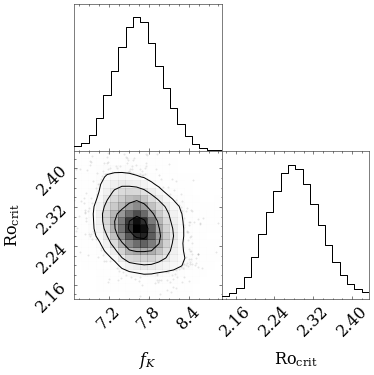

In [75]:
samples = pm.trace_to_dataframe(trace, varnames=['fk', 'rocrit'])
# with plt.rc_context({"axes.labelpad":10}):
_ = corner.corner(samples, labels=[r'$f_K$', r'Ro$_{\rm crit}$'], 
                  plot_datapoints=True, smooth=True, smooth1d=True, labelpad=.05, max_n_ticks=4, dpi=200);

fig = plt.gcf()
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig('/Users/nksaunders/Desktop/corner.pdf', format='pdf', dpi=200)

In [76]:
np.median(samples['fk']), np.median(samples['rocrit'])

(7.64169977357443, 2.2806149280021324)

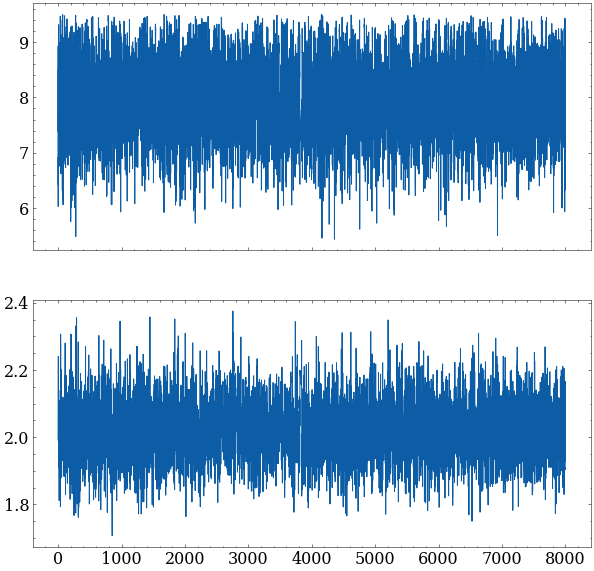

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
ax[0].plot(samples['fk'])
ax[1].plot(samples['rocrit'])

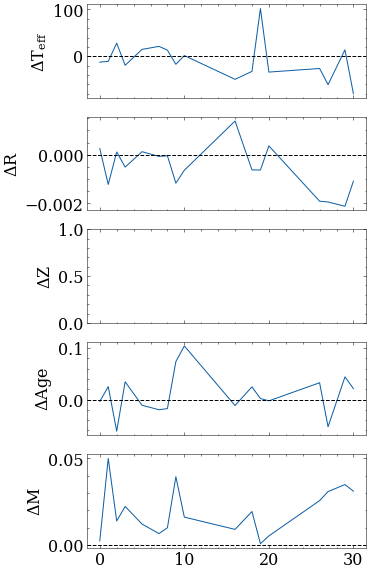

In [43]:
fig, ax = plt.subplots(5,1, figsize=(5,10), sharex=True)
ax[0].plot(data['Teff'] - np.median(trace['teff'], 0))
ax[1].plot(data['R'] - np.median(trace['radius'], 0))
# ax[2].plot((np.log10(data['Zsurf']) - np.log10(.023)) - np.median(trace['fehs'], 0))
ax[3].plot((data['Age'] - np.median(trace['age'], 0))/data['Age'])
ax[4].plot(data['M'] - np.median(trace['mass'], 0))

ax[0].set_ylabel(r'$\Delta$T$_{\rm eff}$')
ax[1].set_ylabel(r'$\Delta$R')
ax[2].set_ylabel(r'$\Delta$Z')
ax[3].set_ylabel(r'$\Delta$Age')
ax[4].set_ylabel(r'$\Delta$M')

ax[0].axhline(0, c='k', linestyle='--')
ax[1].axhline(0, c='k', linestyle='--')
ax[2].axhline(0, c='k', linestyle='--')
ax[3].axhline(0, c='k', linestyle='--')
ax[4].axhline(0, c='k', linestyle='--')

###### 

In [197]:
np.argmax(np.abs(data['Age'] - np.median(trace['age'], 0)))

6

In [217]:
data['feh'][6], np.median(trace['fehs'], 0)[6]

(-0.1476216906427309, -0.26413286579306605)

In [93]:
samples = pm.trace_to_dataframe(trace, varnames=['fk', 'rocrit', 
                                                 'mass', 'radius',
                                                 'teff', 'age'])
# df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(5777))

In [94]:
sampled_teff = []
sampled_mass = []
sampled_rads = []
sampled_ages = []
for i in range(len(data)):
    sampled_teff.append(np.median(samples[f'teff__{i}']))
    sampled_mass.append(np.median(samples[f'mass__{i}']))
    sampled_rads.append(np.median(samples[f'radius__{i}']))
    sampled_ages.append(np.median(samples[f'age__{i}']))

In [95]:
sampled_logL = 2 * np.log10(sampled_rads) + 4 * (np.log10(sampled_teff) - np.log10(5777))
sim_logL = 2 * np.log10(data['R']) + 4 * (np.log10(data['Teff']) - np.log10(5777))

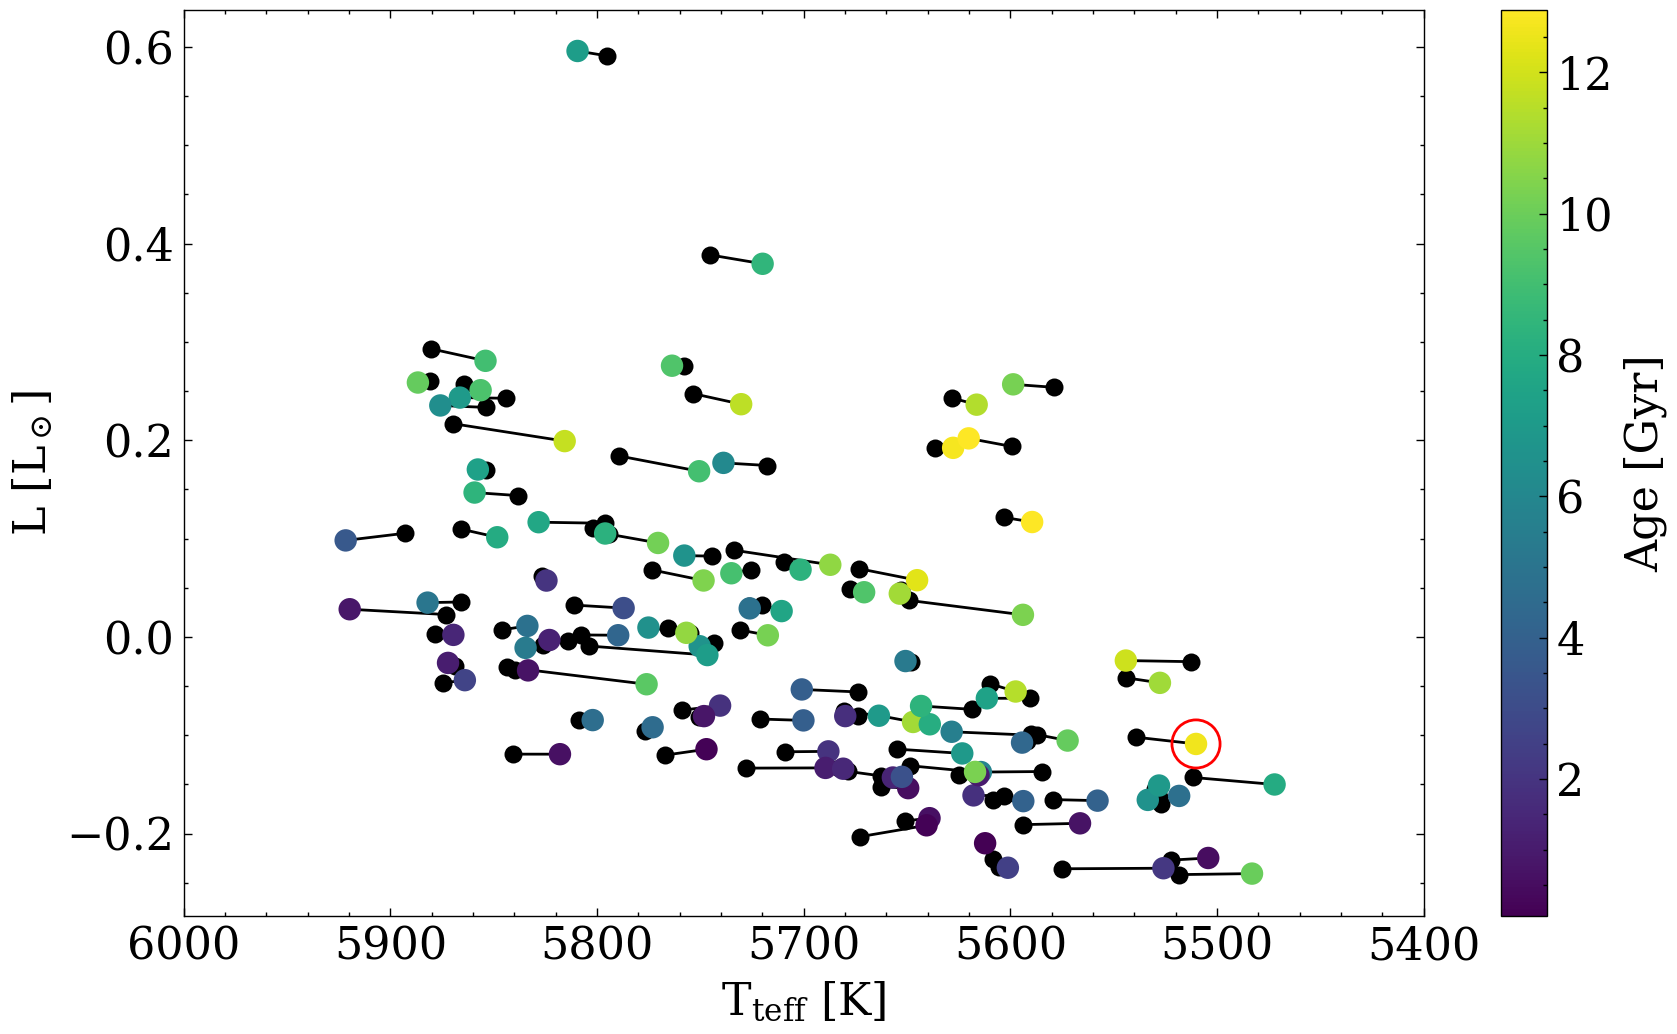

In [208]:
plt.figure(figsize=(10,6), dpi=200)
plt.scatter(data['Teff'], sim_logL, c='k', s=30)
plt.scatter(sampled_teff, sampled_logL, s=50, c=sampled_ages)
plt.colorbar(label='Age [Gyr]')
for i in range(len(data)):
    plt.plot([sampled_teff[i], data['Teff'][i]], [sampled_logL[i], sim_logL[i]], c='k', zorder=-1)
plt.scatter(sampled_teff[6], sampled_logL[6], c='none', edgecolors='r', s=300)
plt.xlim(6000, 5400); 
plt.xlabel(r'T$_{\rm teff}$ [K]'); plt.ylabel(r'L [L$_\odot$]');

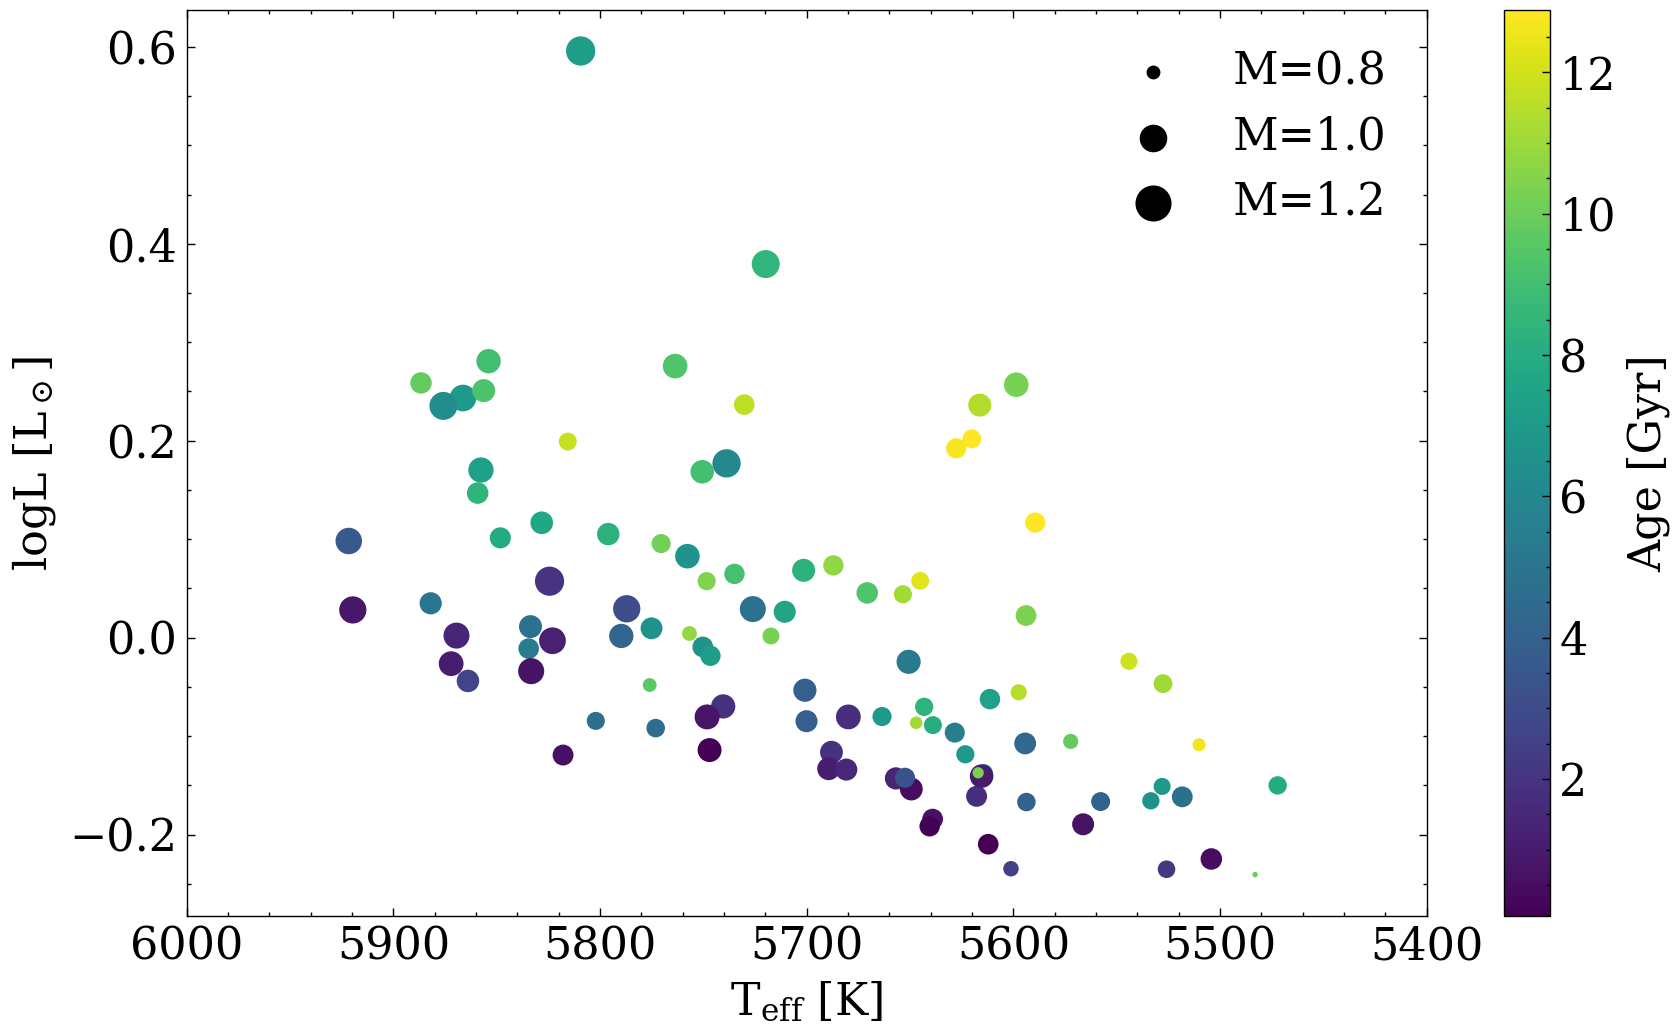

In [188]:
plt.figure(figsize=(10,6), dpi=200)
# plt.scatter(data['Teff'], sim_logL, c='gray', s=50)
plt.scatter(0,0, s=90*(.25+(.8 - min(sampled_mass)) / (max(sampled_mass) - min(sampled_mass))), label='M=0.8', c='k')
plt.scatter(0,0, s=90*(.25+(1. - min(sampled_mass)) / (max(sampled_mass) - min(sampled_mass))), label='M=1.0', c='k')
plt.scatter(0,0, s=90*(.25+(1.2 - min(sampled_mass)) / (max(sampled_mass) - min(sampled_mass))), label='M=1.2', c='k')
s = .01+(sampled_mass - min(sampled_mass)) / (max(sampled_mass) - min(sampled_mass))
plt.scatter(sampled_teff, sampled_logL, s=90*s, c=sampled_ages)
plt.xlim(6000, 5400); plt.colorbar(label='Age [Gyr]')
plt.legend()
plt.xlabel(r'T$_{\rm eff}$ [K]'); plt.ylabel(r'logL [L$_\odot$]');

In [156]:
np.median(samples['fk']), np.median(samples['rocrit'])

(7.669729042506052, 2.2276990804503956)

In [46]:
age_p_trace = pm.trace_to_dataframe(trace, varnames=['prot', 'age', 'teff'])
p_s = ['prot__0','prot__1','prot__2','prot__3','prot__4','prot__5','prot__6','prot__7','prot__8',
       'prot__9','prot__10','prot__11','prot__12','prot__13','prot__14','prot__15','prot__16']
a_s = ['age__0','age__1','age__2','age__3','age__4','age__5','age__6','age__7','age__8',
       'age__9','age__10','age__11','age__12','age__13','age__14','age__15','age__16']
feh_s = ['age__0','age__1','age__2','age__3','age__4','age__5','age__6','age__7','age__8',
       'age__9','age__10','age__11','age__12','age__13','age__14','age__15','age__16']

In [113]:
np.median(pm.trace_to_dataframe(trace, varnames=['teff']), 0)

array([5728.76449535, 5577.39664663, 5580.55565391, 5662.2895969 ,
       5605.46195732, 5671.14661905, 5580.47821329, 5678.69939377,
       5751.4415185 , 5649.45504412, 5797.44645147, 5799.15266156,
       5744.33922094, 5745.30433408, 5649.93405317, 5572.45849746,
       5505.65165498, 5586.51782517, 5461.96225233, 5928.85779508,
       5821.82913632, 5698.06150998, 5664.84142668, 5890.62080775,
       5773.33652732, 5651.96971069, 5653.04436544, 5804.85960759,
       5868.07606958, 5764.51970869, 5878.80763131, 5724.06876769,
       5866.86386644, 5590.89655879, 5728.18171532, 5838.43184992,
       5790.52142231, 5485.43660492, 5775.58218408, 5658.89500382,
       5571.28880785, 5724.97965772, 5588.81773982, 5845.68712726,
       5682.48289173, 5745.08502539, 5680.41033463, 5540.41749242,
       5881.84960703, 5668.38711243, 5889.73906668, 5545.72987674,
       5619.37692669, 5873.65368638, 5768.38658834, 5585.80959986,
       5625.78902173, 5800.99678062, 5731.01228225, 5876.28102

In [744]:
data['Teff']

0      5518.998427
2      5667.072569
4      5565.317694
5      5794.786146
6      5716.424516
          ...     
121    5756.142672
122    5712.727714
123    5665.979226
125    5854.169255
126    5507.843406
Name: Teff, Length: 100, dtype: float64

In [65]:
grid8_evolved = "/Volumes/Nick's Movies/rot_evolved"
solar_files = ['m1000zh0ml160fk500ro100.csv',
               'm1000zh0ml160fk500ro150.csv',
               'm1000zh0ml160fk500ro200.csv', 
               'm1000zh0ml160fk500ro250.csv',
               'm1000zh0ml160fk500ro300.csv',
               'm1000zh0ml160fk500ro350.csv',
               'm1000zh0ml160fk500ro400.csv']

fig = plt.figure(dpi=200, figsize=(7,5)); fig.patch.set_facecolor('w')
outfiles = os.listdir(grid8_evolved)
for fname,label in zip(solar_files, [r'Ro$_{\rm crit}=1.0$',
                                     r'Ro$_{\rm crit}=1.5$',
                                     r'Ro$_{\rm crit}=2.0$',
                                     r'Ro$_{\rm crit}=2.5$',
                                     r'Ro$_{\rm crit}=3.0$',
                                     r'Ro$_{\rm crit}=3.5$',
                                     r'Ro$_{\rm crit}=4.0$']):
    df = pd.read_csv(os.path.join(grid8_evolved, fname))
    plt.plot(df['Age(Gyr)'][:500], df['Prot(days)'][:500], label=label)
    
for i in range(17):
    plt.scatter(np.median(age_p_trace[a_s[i]]), np.median(age_p_trace[p_s[i]]), c='k', zorder=1000)
    plt.errorbar(np.median(age_p_trace[a_s[i]]), np.median(age_p_trace[p_s[i]]),
                 xerr=np.std(age_p_trace[a_s[i]]), yerr=np.std(age_p_trace[p_s[i]]), c='k', zorder=1000)
    
plt.annotate(r'$\odot$', (4.6, 25.4), zorder=100)
plt.xlabel('Age [Gyr]'); plt.ylabel(r'P$_{\rm rot}$ [days]');
plt.legend(fontsize=12);

FileNotFoundError: [Errno 2] No such file or directory: "/Volumes/Nick's Movies/rot_evolved"

<Figure size 1400x1000 with 0 Axes>

In [746]:
pm.trace_to_dataframe(trace, varnames=['prot'])

,prot__0,prot__1,prot__2,prot__3,prot__4,prot__5,prot__6,prot__7,prot__8,prot__9,...,prot__90,prot__91,prot__92,prot__93,prot__94,prot__95,prot__96,prot__97,prot__98,prot__99
0,34.411954,30.040494,16.670707,20.763029,27.187991,25.168231,25.520915,32.999382,28.628804,24.829994,...,36.335909,30.341119,28.509537,23.773126,25.728935,30.950964,22.885973,22.336841,22.427592,25.641529
1,29.191509,36.764918,14.938465,19.685679,26.200953,24.515866,21.924786,30.745019,28.633425,22.169760,...,34.260843,31.589978,33.002038,22.603318,33.560138,26.264819,19.382364,21.453585,20.862274,28.811688
2,30.506286,37.244286,17.302704,19.373580,26.208964,25.907999,26.213342,25.984247,24.706978,25.460289,...,38.064082,30.121919,31.488419,19.700143,35.647840,28.362130,24.005955,26.696002,19.486752,26.866596
3,32.305399,41.046532,16.999483,19.456044,21.908493,25.763952,20.437923,32.237803,26.942061,22.442647,...,36.837079,25.062318,31.713708,20.682435,31.150627,27.491319,24.122287,24.202827,18.436749,29.970652
4,30.403734,34.971530,18.951378,17.183690,28.359927,21.882390,23.152141,29.964616,28.595909,25.724615,...,36.713833,24.420602,23.386393,21.600752,23.766273,26.933946,21.362266,28.414702,18.384266,29.668837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,35.002640,37.440802,24.164372,22.548505,27.632875,31.595863,30.397974,30.299132,23.154712,25.574775,...,30.431179,26.332894,30.258759,22.574300,29.660605,21.564550,24.299879,24.379194,19.211728,32.695379
396,37.782080,34.812014,20.125284,22.292855,26.504327,20.213685,26.404884,31.350964,27.843477,26.291038,...,41.364284,29.802541,30.010223,23.718432,35.153224,21.442280,22.350778,26.642283,20.277788,23.991166
397,36.253215,35.607874,18.945711,22.986144,26.662389,24.571337,27.654254,25.734138,26.707223,22.589393,...,31.191045,28.462038,28.074663,22.591877,30.376806,28.648328,25.776789,24.974928,19.842349,27.947878
398,38.249661,33.289632,19.847883,21.249157,25.358417,26.481461,28.595911,33.178774,24.231679,30.066319,...,38.903466,28.273017,32.947794,21.266362,36.162583,20.496637,19.820026,27.890289,20.113367,26.742998


In [365]:
# solar_evolved = ["/Users/nksaunders/Desktop/m1000zh0ml160fk745ro208.csv"]
solar_evolved = ['/Users/nksaunders/Desktop/m1000zh0ml160fk773ro166.csv']

fig = plt.figure(dpi=200, figsize=(7,5)); fig.patch.set_facecolor('w')

# for fname,label in zip(solar_evolved, [r'$f_K=7.731$, Ro$_{\rm crit}=1.661$']):
#     df = pd.read_csv(os.path.join(grid8_evolved, fname))
#     plt.plot(df['Age(Gyr)'][:500], df['Prot(days)'][:500], label=label, c='r')
    

# for i in range(3):
plt.scatter(np.median(age_p_trace[a_s], 0), np.median(age_p_trace[p_s], 0), 
            c='k', zorder=1000)
# c=np.array(data['M'])
plt.errorbar(np.median(age_p_trace[a_s], 0), np.median(age_p_trace[p_s], 0),
             xerr=np.std(age_p_trace[a_s], 0), yerr=np.std(age_p_trace[p_s], 0), 
             c='k', zorder=100, lw=0, elinewidth=1)
    
plt.annotate(r'$\odot$', (4.6, 25.4), zorder=100)
plt.xlabel('Age [Gyr]'); plt.ylabel(r'P$_{\rm rot}$ [days]');
plt.legend(fontsize=12, loc=2);
# plt.clim(-.3, .3)
# plt.colorbar(label='M')

# plt.savefig('/Users/nksaunders/Desktop/p_vs_t.pdf', format='pdf', dpi=200)

In [650]:
np.median(age_p_trace[a_s], 0)

array([11.28847263, 11.32038274,  5.2844881 ,  4.13516756,  4.73229765,
        4.56548666, 10.36796209,  6.21962207,  8.07782311, 10.84717249,
        8.21369186,  7.75136547,  7.17570716,  6.95407994,  7.84267192,
        8.03462916,  5.81261714])

In [325]:
np.array(data['feh'])

array([-0.06,  0.25, -0.04,  0.08, -0.23,  0.02, -0.01,  0.19,  0.05,
       -0.29, -0.18,  0.1 , -0.31, -0.19, -0.2 ,  0.1 ,  0.05])

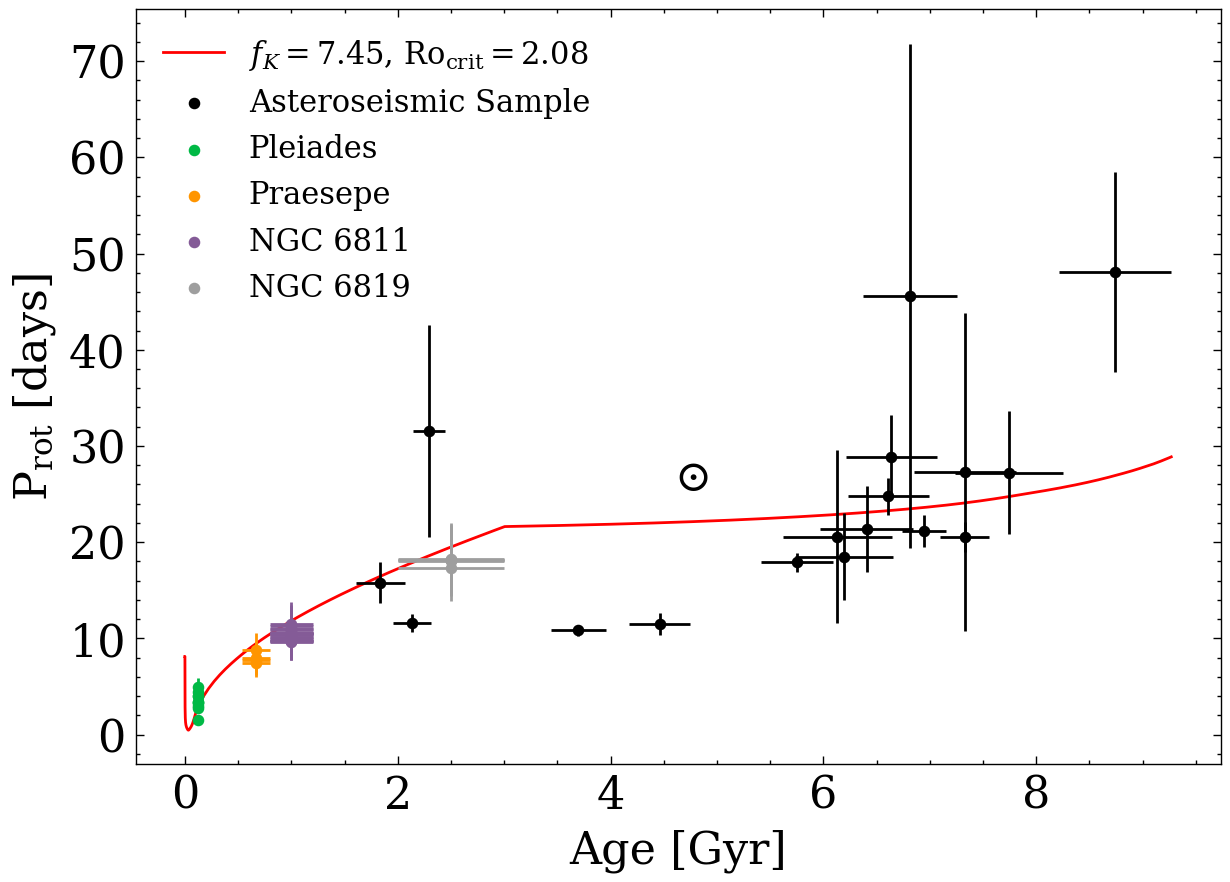

In [67]:
solar_evolved = ["/Users/nksaunders/Desktop/test_tracks/m1000zh0ml160fk900ro208.csv"]
# solar_evolved = ['/Users/nksaunders/Desktop/m1000zh0ml160fk773ro166.csv']

fig = plt.figure(dpi=200, figsize=(7,5)); fig.patch.set_facecolor('w')

for fname,label in zip(solar_evolved, [r'$f_K=7.45$, Ro$_{\rm crit}=2.08$']):
    df = pd.read_csv(fname)
    plt.plot(df['Age(Gyr)'][:500], df['Prot(days)'][:500], label=label, c='r')
    

# ASTEROSEISMIC SAMPLE
plt.scatter(data[:17]['Age'], data[:17]['P'], 
            c='k', zorder=1000, s=10, label='Asteroseismic Sample')
# c=np.array(data['M'])
plt.errorbar(data[:17]['Age'], data[:17]['P'],
             xerr=data[:17]['err_Age'], yerr=data[:17]['err_P'], 
             c='k', zorder=100, lw=0, elinewidth=1)

# PLEIADES
plt.scatter(data[17:27]['Age'], data[17:27]['P'], 
            c='C1', zorder=1000, s=10, label='Pleiades')
# c=np.array(data['M'])
plt.errorbar(data[17:27]['Age'], data[17:27]['P'],
             xerr=data[17:27]['err_Age'], yerr=data[17:27]['err_P'], 
             c='C1', zorder=100, lw=0, elinewidth=1)

# PRAESEPE
plt.scatter(data[27:31]['Age'], data[27:31]['P'], 
            c='C2', zorder=1000, s=10, label='Praesepe')
# c=np.array(data['M'])
plt.errorbar(data[27:31]['Age'], data[27:31]['P'],
             xerr=data[27:31]['err_Age'], yerr=data[27:31]['err_P'], 
             c='C2', zorder=100, lw=0, elinewidth=1)

# NGC 6811
plt.scatter(data[31:48]['Age'], data[31:48]['P'], 
            c='C4', zorder=1000, s=10, label='NGC 6811')
# c=np.array(data['M'])
plt.errorbar(data[31:48]['Age'], data[31:48]['P'],
             xerr=data[31:48]['err_Age'], yerr=data[31:48]['err_P'], 
             c='C4', zorder=100, lw=0, elinewidth=1)

# NGC 6819
plt.scatter(data[48:]['Age'], data[48:]['P'], 
            c='C6', zorder=1000, s=10, label='NGC 6819')
# c=np.array(data['M'])
plt.errorbar(data[48:]['Age'], data[48:]['P'],
             xerr=data[48:]['err_Age'], yerr=data[48:]['err_P'], 
             c='C6', zorder=100, lw=0, elinewidth=1)
    
plt.annotate(r'$\odot$', (4.6, 25.4), zorder=100)
plt.xlabel('Age [Gyr]'); plt.ylabel(r'P$_{\rm rot}$ [days]');
plt.legend(fontsize=11, loc=2);
# plt.clim(-.3, .3)
# plt.colorbar(label='M')

# plt.savefig('/Users/nksaunders/Desktop/p_vs_t.pdf', format='pdf', dpi=200)

(-1.0, 55.0)

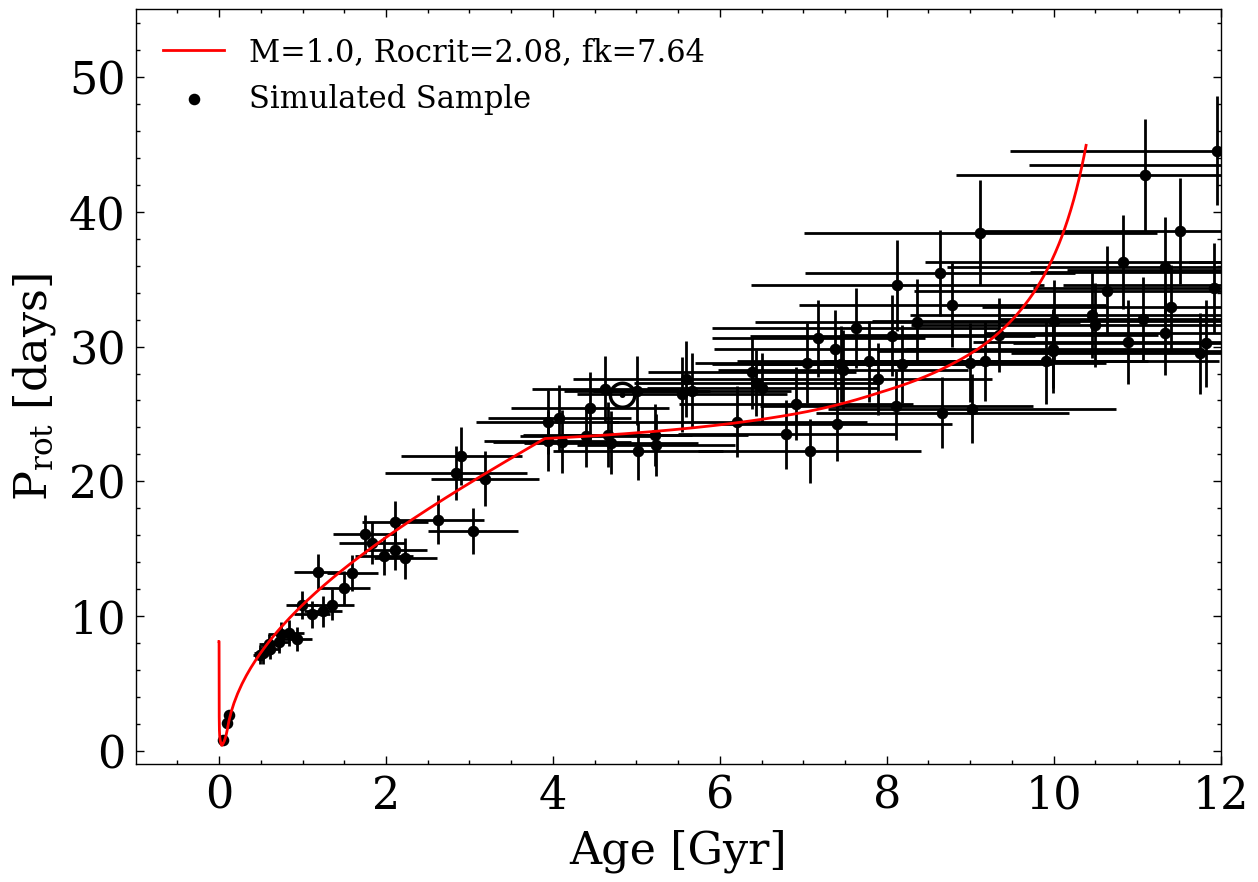

In [77]:
# solar_evolved = ["/Users/nksaunders/Desktop/m1000zh0ml160fk745ro208.csv"]
solar_evolved = ['/Users/nksaunders/Desktop/test_tracks/m1000zh0ml160fk764ro228.csv']
#                  '/Users/nksaunders/Desktop/test_tracks/m0800zh0ml160fk766ro222.csv',
#                  '/Users/nksaunders/Desktop/test_tracks/m0900zh0ml160fk766ro222.csv',
#                  '/Users/nksaunders/Desktop/test_tracks/m1000zh0ml160fk766ro222.csv',
#                  '/Users/nksaunders/Desktop/test_tracks/m1100zh0ml160fk766ro222.csv',
#                  '/Users/nksaunders/Desktop/test_tracks/m1200zh0ml160fk766ro222.csv'
#                  ]

fig = plt.figure(dpi=200, figsize=(7,5)); fig.patch.set_facecolor('w')

for fname,label in zip(solar_evolved, [r'M=1.0, Rocrit=2.08, fk=7.64', 'M=0.9', 'M=1.0', 'M=1.1', 'M=1.2']):
# for fname in solar_evolved:
    df = pd.read_csv(fname)
    plt.plot(df['Age(Gyr)'][:700], df['Prot(days)'][:700], zorder=1000, label=label, c='r')
    

# ASTEROSEISMIC SAMPLE
plt.scatter(data['Age'], data['P'], 
            c='k', zorder=1000, s=10, label='Simulated Sample')
# c=np.array(data['M'])
plt.errorbar(data['Age'], data['P'],
             xerr=data['err_Age'], yerr=data['err_P'], 
             c='k', zorder=100, lw=0, elinewidth=1)

    
plt.annotate(r'$\odot$', (4.6, 25.4), zorder=100)
plt.xlabel('Age [Gyr]'); plt.ylabel(r'P$_{\rm rot}$ [days]');
plt.legend(fontsize=11, loc=2);
plt.xlim(-1,12)
plt.ylim(-1,55)
# plt.clim(-.3, .3)

In [60]:
n=10000
test_data = sim_data[:n]
test_data['log(Age)(Gyr)'] = np.log10(test_data['Age'])
test_data['fk'] = np.ones(n) * 7.
test_data['rocrit'] = np.ones(n) * 2.3

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [61]:
%%time
input_cols = ['log(Age)(Gyr)', 'M', 'feh', 'alpha', 'fk', 'rocrit']
out = model.predict(test_data[input_cols])

CPU times: user 261 ms, sys: 29.3 ms, total: 291 ms
Wall time: 236 ms
